## Network analysis

### 1. Data preprocessing and visualization

In [1]:
import pandas as pd

# Import the data
applications = pd.read_json('D:\\events\\applications.json')

# Print overview
applications.head(3)

,appIdConsumer,appIdProvider,beatId,beatType,callId,callMode,callScope,correlationId,durationMs,eventTime,...,orgBezeichnung,orgId,orgKurzbezeichnung,orgSubkategorien,parentCallId,role,stage,tkNameIdConsumer,tkNameIdProvider,userId
0,spoud-app,sim-provider,0,ServiceProviderBeat,0,SYNC,LOCAL,6ee2fa2b-a1ca-405e-9088-94dbb834730f,201,2018-05-05T07:55:38.422185+00:00,...,Bellinzona,na,na,GA,superloser,provider,SIM,spoud-portal,tm4-Mond-52,SIMU147400
1,spoud-app,sim-provider,2,ServiceProviderBeat,2,SYNC,LOCAL,7aa2e01f-4af6-48e8-ae98-a42fe9fc6e5d,201,2018-05-05T07:55:38.432086+00:00,...,Lyss,na,na,GA,superloser,provider,SIM,spoud-portal,tm4-Mond-52,SIMU534284
2,spoud-app,sim-provider,4,ServiceProviderBeat,4,SYNC,LOCAL,f722a638-7e0d-4f19-86ad-7aeecbffa40f,201,2018-05-05T07:55:38.441987+00:00,...,Winterthur,na,na,GA,superloser,provider,SIM,spoud-portal,tm4-Mond-52,SIMU816207


In [2]:
# Print some initial statistics
applications.describe()

,beatId,callId,durationMs,meta_linecount,meta_version
count,1.296000e+06,1.296000e+06,1.296000e+06,1296000.0,1.296000e+06
mean,1.799000e+03,1.169906e+02,3.598675e+02,1.0,1.000000e-01
std,1.039231e+03,8.128626e+01,1.350601e+02,0.0,2.357893e-12
min,0.000000e+00,0.000000e+00,2.000000e+02,1.0,1.000000e-01
25%,8.995000e+02,4.950000e+01,2.690000e+02,1.0,1.000000e-01
50%,1.799000e+03,1.020000e+02,3.400000e+02,1.0,1.000000e-01
75%,2.698500e+03,1.760000e+02,4.250000e+02,1.0,1.000000e-01
max,3.598000e+03,3.180000e+02,1.955000e+03,1.0,1.000000e-01


In [219]:
# Check for missing values
null_values = applications.isnull().sum()
null_values[null_values != 0]

Series([], dtype: int64)

#### Worktime calculation

$$\large w_t = \bar{r}_n * n_c $$

($ w_t $ = worktime,
$ r_t $ = response time,
$ n_c $ = throughput / number of service calls)


In [425]:
applications['fkNameProvider'].unique()

array(['fkNameProvider'], dtype=object)

In [30]:
# Overview of involved components
tk_field, event_time_field, duration_field = 'tkNameIdProvider', 'eventTime', 'durationMs'
id_fields = ['appIdProvider', 'fkNameProvider', tk_field]
unique_components = zip([id_field for id_field in id_fields], 
                        ['Application', 'Functional component', 'Technical component'])
for field, name in unique_components:
    unique_components = applications[field].unique()
    print('%d %s\'s:' % (unique_components.size, name), end=' ')
    print(', '.join(str(c) for c in unique_components))

1 Application's: sim-provider
1 Functional component's: fkNameProvider
18 Technical component's: tm4-Mond-52, tm4-Phobos-52, tm4-Deimos-52, tm4-Adrastea-52, tm4-Metis-52, tm4-Amalthea-52, tm4-Thebe-52, tm4-Io-52, tm4-Europa-52, tm4-Ganymed-52, tm4-Kallisto-52, tm4-Themisto-52, tm4-Leda-52, tm4-Himalaia-52, tm4-Lysithea-52, tm4-Elara-52, tm4-Carpo-52, tm4-Euporie-52


In [60]:
# Create dataset with one minute buckets and only relevant information
performance = applications[[tk_field, duration_field, event_time_field]]
performance = performance.set_index(event_time_field)
performance.index = pd.to_datetime(performance.index)

In [82]:
# Evaluate time delta of measurements
performance.index.max() - performance.index.min()

Timedelta('0 days 11:59:00.993711')

In [252]:
# Group the data into one minutes bin grouped by technical component
#performance_bins = performance.groupby(tk_field).resample('1T').sum() \
#    .reset_index() \
#    .pivot(index='eventTime', columns='tkNameIdProvider', values='durationMs')

In [223]:
# Build a dicitionary with all components
all_components = {}

# Method for building statistics for group
def aggregate_stats(group):
    number_of_requests = group_component.count()
    total_duration = group_component.sum()
    avg_response_time = total_duration / number_of_requests
    # (Inconsistend definition in document
    # worktime = avg_response_time * number_of_requests)
    performance_of_component = pd.DataFrame({'component_name': technical_component,  
                                             'worktime' : total_duration, 
                                             'throughput' : number_of_requests, 
                                             'response_time' : avg_response_time})
    return performance_of_component

for technical_component in performance[tk_field].unique():       
    group_component = performance.loc[performance[tk_field] == technical_component] \
        .resample('1T')[duration_field]
    all_components[technical_component] = aggregate_stats(group_component)

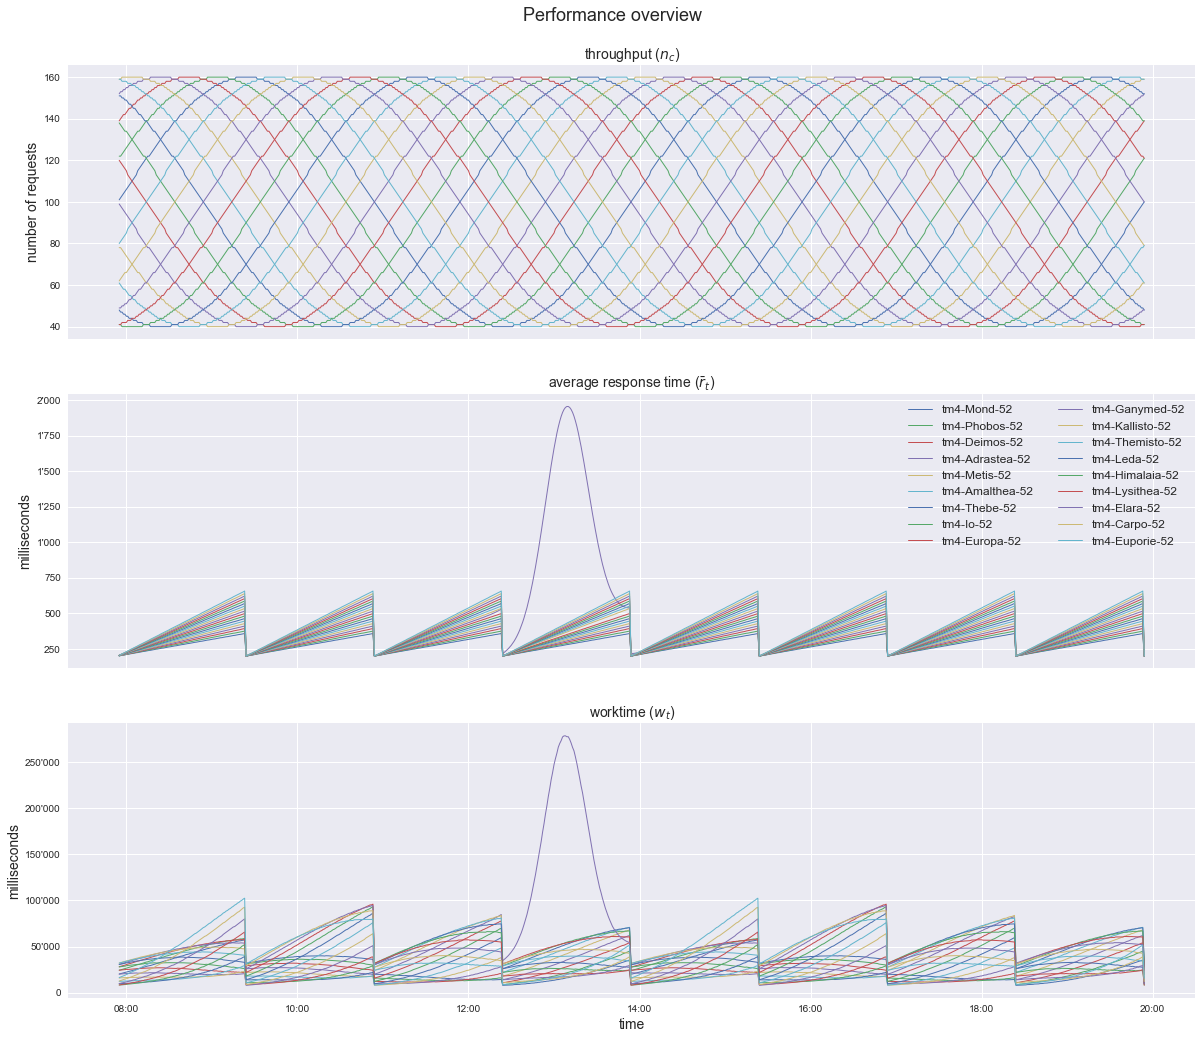

In [359]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import locale
import numpy as np

# Set searborn style for plot
plt.style.use('seaborn')

# Plot metrics for comparision
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18,16))
plt.suptitle('Performance overview', fontsize=18, y=.93)
thousand_formatter = plt.FuncFormatter(lambda x, _ : locale.format("%d", x, grouping=True))
for component in all_components.values():
    
    ax1.plot(component['throughput'], linewidth=1)
    ax1.set_title('throughput ($ n_c $)', fontsize=14)
    ax1.set_ylabel('number of requests', fontsize=14)
    
    ax2.plot(component['response_time'], linewidth=1)
    ax2.set_title('average response time ($ \\bar{r}_t $)', fontsize=14)
    ax2.yaxis.set_major_formatter(thousand_formatter)
    ax2.set_ylabel('milliseconds', fontsize=14)
    
    ax3.plot(component['worktime'], linewidth=1)
    ax3.set_title('worktime ($ w_t $)', fontsize=14)
    ax3.set_ylabel('milliseconds', fontsize=14)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))    
    ax3.yaxis.set_major_formatter(thousand_formatter)
    ax3.set_xlabel('time of day', fontsize=14)

ax2.legend(all_components.keys(), ncol=2, prop={'size': 12})
plt.show()

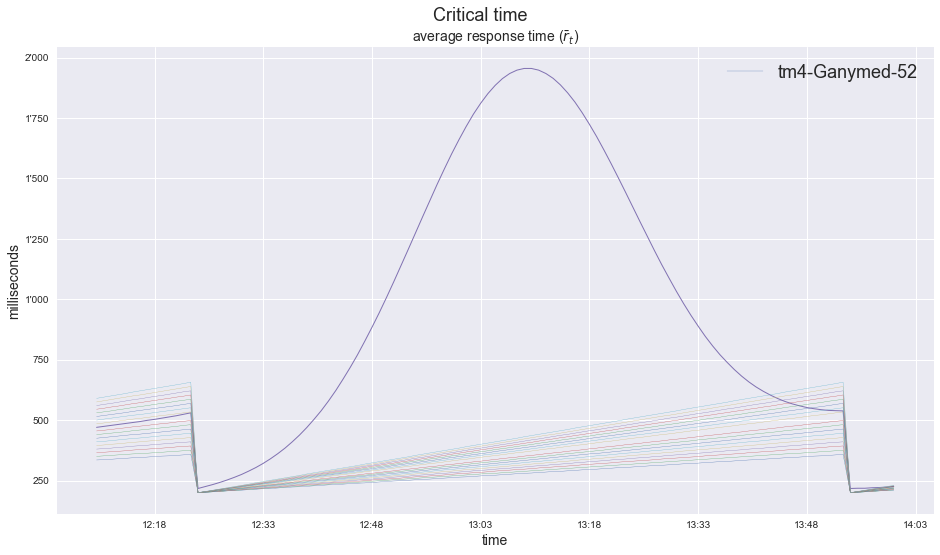

In [499]:
# Have a closer look at the critical time
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(14,8))
plt.suptitle('Critical time', fontsize=18, y=.95)
for name, component in all_components.items():
    
    ax.plot(component['2018-05-05 12:10:00':'2018-05-05 14:00:00']['response_time'], 
            linewidth=1 if name == 'tm4-Ganymed-52' else .3)
    ax.set_title('average response time ($ \\bar{r}_t $)', fontsize=14)
    ax.yaxis.set_major_formatter(thousand_formatter)
    ax.set_ylabel('milliseconds', fontsize=14)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))    
    ax.yaxis.set_major_formatter(thousand_formatter)
    ax.set_xlabel('time', fontsize=14)

ax.legend(['tm4-Ganymed-52'], ncol=2, prop={'size': 18})
plt.show()

### 2. Time series forecasting

In [509]:
# Choose components for forecasting
performance[performance[tk_field] == 'tm4-Mond-52'].count()

tkNameIdProvider    72000
durationMs          72000
dtype: int64

### 3. Correlating the layers